### ANALYZE THE NEWS, AND PREDICT THE SENTIMENT ABOUT A PARTICULAR STOCK (WHETHER TO POSITIIVE OR NEGATIVE OR NEUTRAL) ###

In [1]:
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('./news_dataset/all-data.csv',encoding='ISO-8859-1')
print(df.columns)
df.columns = ['Sentiment', 'Headlines']
print(df.columns)

Index(['neutral', 'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .'], dtype='object')
Index(['Sentiment', 'Headlines'], dtype='object')


In [3]:
print(df)
print(df['Sentiment'].dtype)

     Sentiment                                          Headlines
0      neutral  Technopolis plans to develop in stages an area...
1     negative  The international electronic industry company ...
2     positive  With the new production plant the company woul...
3     positive  According to the company 's updated strategy f...
4     positive  FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
...        ...                                                ...
4840  negative  LONDON MarketWatch -- Share prices ended lower...
4841   neutral  Rinkuskiai 's beer sales fell by 6.5 per cent ...
4842  negative  Operating profit fell to EUR 35.4 mn from EUR ...
4843  negative  Net sales of the Paper segment decreased to EU...
4844  negative  Sales in Finland decreased by 10.5 % in Januar...

[4845 rows x 2 columns]
object


In [4]:
df['Sentiment'] = df['Sentiment'].str.lower().str.strip()
df['Sentiment'] = df['Sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})
df

,Sentiment,Headlines
0,0,Technopolis plans to develop in stages an area...
1,-1,The international electronic industry company ...
2,1,With the new production plant the company woul...
3,1,According to the company 's updated strategy f...
4,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
...,...,...
4840,-1,LONDON MarketWatch -- Share prices ended lower...
4841,0,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4842,-1,Operating profit fell to EUR 35.4 mn from EUR ...
4843,-1,Net sales of the Paper segment decreased to EU...


In [5]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation/numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['Headlines'] = df['Headlines'].apply(clean_text)
df

,Sentiment,Headlines
0,0,technopolis plans to develop in stages an area...
1,-1,the international electronic industry company ...
2,1,with the new production plant the company woul...
3,1,according to the company s updated strategy fo...
4,1,financing of aspocomp s growth aspocomp is agg...
...,...,...
4840,-1,london marketwatch share prices ended lower in...
4841,0,rinkuskiai s beer sales fell by per cent to mi...
4842,-1,operating profit fell to eur mn from eur mn in...
4843,-1,net sales of the paper segment decreased to eu...


In [6]:
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Headlines'])

sequences = tokenizer.texts_to_sequences(df['Headlines'])
print(sequences[:5])

[[751, 291, 6, 790, 4, 1661, 34, 162, 3, 211, 1072, 87, 551, 1662, 4, 105, 6, 3247, 77, 709, 4, 1156, 501, 5, 667, 2, 835, 22], [2, 242, 578, 122, 13, 279, 18, 1157, 324, 3248, 3, 139, 14, 16, 1073, 235, 4637, 6, 126, 502, 2, 13, 2158, 2, 4638, 3, 16, 221, 877, 2, 791, 4639, 204], [19, 2, 41, 71, 82, 2, 13, 111, 94, 16, 222, 6, 1356, 2, 133, 94, 4, 434, 5, 111, 579, 2, 184, 3, 611, 456, 5, 1492, 94, 2, 71, 1074], [78, 6, 2, 13, 10, 2159, 292, 9, 2, 223, 252, 989, 7, 457, 30, 27, 168, 4, 2, 316, 3, 19, 34, 37, 31, 435, 3, 3, 30, 27], [792, 3, 479, 10, 168, 479, 11, 4640, 4641, 16, 168, 292, 20, 2160, 1357, 15, 3249, 95, 1663, 4642, 1358, 1075, 1664, 2577]]


In [7]:
max_length = 0
for tokens in sequences:
    if(len(tokens) > max_length):
        max_length = len(tokens)
print(max_length)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
print(padded_sequences[:5])

50
[[ 751  291    6  790    4 1661   34  162    3  211 1072   87  551 1662
     4  105    6 3247   77  709    4 1156  501    5  667    2  835   22
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   2  242  578  122   13  279   18 1157  324 3248    3  139   14   16
  1073  235 4637    6  126  502    2   13 2158    2 4638    3   16  221
   877    2  791 4639  204    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [  19    2   41   71   82    2   13  111   94   16  222    6 1356    2
   133   94    4  434    5  111  579    2  184    3  611  456    5 1492
    94    2   71 1074    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [  78    6    2   13   10 2159  292    9    2  223  252  989    7  457
    30   27  168    4    2  316    3   19   34   37   31  435    3    3
    30   27    0    0    0    0    0    0    0    0    0    0    0    0
    

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(padded_sequences, df['Sentiment'], test_size=0.2, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(3876, 50) (3876,)
(969, 50) (969,)


In [9]:
label_Encoder = LabelEncoder()
Y_train = label_Encoder.fit_transform(Y_train)
Y_test = label_Encoder.transform(Y_test)
Y_train = to_categorical(Y_train, num_classes=3)
Y_test = to_categorical(Y_test, num_classes=3)
print(Y_train[:5])
print(Y_test[:5])
print("Vocabulary Size:", len(tokenizer.word_index) + 1)
print("Number of Classes:", len(label_Encoder.classes_))
print("Max Length of Sequences:", max_length)
print(Y_train.shape, Y_test.shape)

[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
Vocabulary Size: 9486
Number of Classes: 3
Max Length of Sequences: 50
(3876, 3) (969, 3)


In [ ]:
model = Sequential()
model.add(Input(shape=(max_length,)))
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length))
model.add(Bidirectional(LSTM(64, return_sequences=True))) #return_sequences tells whether to give only final output or output of wach layer
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))


c:\Users\shitp\OneDrive\Desktop\AlgoTrading\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [11]:
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)
optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 128)        │     1,214,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,354,435 (5.17 MB)

 Trainable params: 1,354,435 (5.17 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(X_train, Y_train, epochs=10, batch_size=64, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.5611 - loss: 0.9596 - val_accuracy: 0.6543 - val_loss: 0.7949
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7039 - loss: 0.7163 - val_accuracy: 0.7018 - val_loss: 0.7546
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7946 - loss: 0.4811 - val_accuracy: 0.6904 - val_loss: 0.8542
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8521 - loss: 0.3690 - val_accuracy: 0.7265 - val_loss: 0.8627
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9270 - loss: 0.2304 - val_accuracy: 0.7379 - val_loss: 0.9849
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9638 - loss: 0.1242 - val_accuracy: 0.7358 - val_loss: 1.0685
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9758 - loss: 0.0976 - val_accuracy: 0.7420 - val_loss: 1.1319
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9846 - loss: 0.0663 - val_accuracy: 0.7276 - v

In [14]:
eval_loss, eval_accuracy = model.evaluate(X_test, Y_test, verbose=1)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7211 - loss: 1.5177


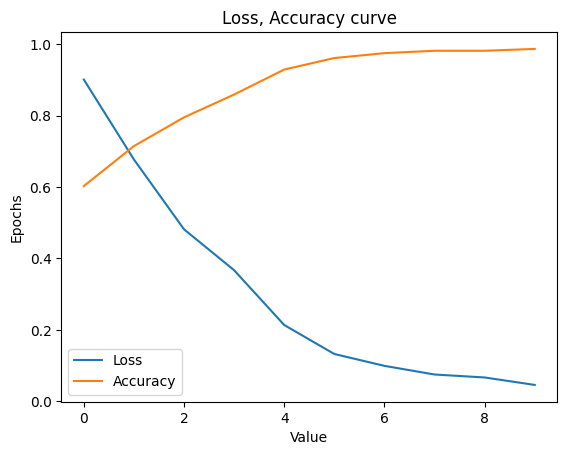

In [ ]:
plt.title("Loss, Accuracy curve")
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.xlabel('epochs')
plt.ylabel('values')
plt.legend()
plt.show()

In [32]:
input_headline = 'Apple is expected to increase its market share in the coming year'
cleaned_input = clean_text(input_headline)
input_sequence = tokenizer.texts_to_sequences([cleaned_input])
input_padded = pad_sequences(input_sequence, maxlen=max_length, padding='post', truncating='post')
predicted_probabilities = model.predict(input_padded)
print(predicted_probabilities)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
[[0.00171454 0.00132694 0.9969585 ]]


In [35]:
predicted_idx = np.argmax(predicted_probabilities, axis=1)
predicted_sentiment = label_Encoder.inverse_transform(predicted_idx)

print(f"Predicted sentiment for input '{input_headline}': {predicted_sentiment[0]}")

if predicted_sentiment[0] == 1:
    output = 'POSITIVE 🙂'
    colored_output = f'\033[92m{output}\033[0m'  # Green
    expect = 'increase'
elif predicted_sentiment[0] == 0:
    output = 'NEUTRAL 😐'
    colored_output = output  # No color
    expect = 'nothing can be exactly expected'
elif predicted_sentiment[0] == -1:
    output = 'NEGATIVE 😞'
    colored_output = f'\033[91m{output}\033[0m'  # Red
    expect = 'decrease'
else:
    output = 'UNKNOWN 😕'
    colored_output = output
    expect = 'unknown'

confidence = predicted_probabilities[0][predicted_idx[0]]

print(
    f"According to the headlines, the stock price is expected to {expect}, "
    f"and the market sentiment is {colored_output} with confidence level {confidence:}"
)


Predicted sentiment for input 'Apple is expected to increase its market share in the coming year': 1
According to the headlines, the stock price is expected to increase, and the market sentiment is POSITIVE 🙂 with confidence level 0.9969584941864014


In [18]:
from keras.models import model_from_json
model_json = model.to_json()
with open("sentiment.json", "w") as json_file:
    json_file.write(model_json)
model.save("sentiment.h5")
print("Model Saved")

Model Saved
